## Purpose

The purpose of this code is to map all .wav files to their spectrograms
and most recent annotations. 

This code will allow the team to join datapoints output from VGGish
to the original spectrogram annotations from Chris and team. This will
allow the VGGish team to ground their clusters in known annotations.

Input(s):
1. Path to unique_images_annotations.csv file. This file contains the
    image_file_name, image_file_path, and json_file_path for all the
    annotated Fred Olsen images from Dec 2018 to Feb 2019.

Output(s):
1. CSV file with each wav file name, metadata file name, image file name,
    json file name, annotation names (e.g., mooring, whale, airplane), and
    the annotation coordinates

Usage:
1. This code will generate a csv which will be joined to the output datapoints
    from the VGGish model.

We'll start by importing some Python libraries

In [1]:
#Imports
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

Now we will pull the information from the annotated JSON files stored on the external hard drive so we can get data labels, sound coordinates, and image file names. This is tricky because the same image may have been annotated multiple times. To ensure that we have pulled the most recent annotated file we will leverage the "unique_images_annotations.csv" generated by the "unique_images_annotations.ipynb". If the csv file doesn't exist, please stop now and run it to generate the csv file.

In [36]:
#Creating a df to save the data in
annotation_df = pd.DataFrame(columns=['sound','points','image_name', 'json_file_path'])
annotation_df.head()

#Getting the path to the JSON files & listing files
uniq_annotation_df = pd.read_csv('unique_images_annotations.csv')
json_file_list = list(uniq_annotation_df['json_file_path'])

#Iterate through json files to get annotated image info
for file in json_file_list:
    #Loading the JSON data & turning into dict
    annotated_file = open(file)
    annotated_dict = json.load(annotated_file)
    #annotated_dict.keys()

    #Pulling out the labels, points, and image path
    image_name = annotated_dict['imagePath']
    if len(annotated_dict['shapes']) > 0:
        for shape in annotated_dict['shapes']:
            sound = shape['label']
            points = shape['points']
            annotation_df.loc[len(annotation_df.index)] = [sound, points, image_name, file]
    else:
        sound = None
        points = None
        annotation_df.loc[len(annotation_df.index)] = [sound, points, image_name, file]
    
#Validating that images paired with json from unique annotations file are the same as the images referenced in the JSON files themselves
comb_df = pd.merge(left = uniq_annotation_df, right = annotation_df, how = 'left', left_on='json_file_path', right_on='json_file_path')
comb_df['image_file_name_tester'] = comb_df['image_file_name']+'.png'
comb_df['name_compare'] = np.where((comb_df['image_file_name_tester'] == comb_df['image_name']), 0, 1)
if comb_df['name_compare'].sum() != 0:
    print("The following json files contain different image filenames than those they were aligned to in the unique_image_annotations code")
    print(comb_df.loc[comb_df['name_compare']!=0])
else:
    pass

#Validating we got all the json files from the original unique annotations dataframe in the new annotation df
if len(uniq_annotation_df) != len(annotation_df['json_file_path'].unique()):
    print("ERROR - not all JSON contained in the annotation_df")
else:
    pass

#Examining head of file
print(annotation_df.head())

           sound                                             points  \
0        mooring  [[382.56626506024094, 614.4819277108433], [458...   
1     helicopter  [[1920.952380952381, 1048.1904761904761], [216...   
2        mooring  [[424.7349397590361, 748.2168674698794], [490....   
3        mooring  [[1209.0722891566263, 938.5783132530119], [127...   
4        mooring  [[1645.2168674698794, 744.6024096385541], [173...   
...          ...                                                ...   
2954    humpback  [[1548.1081081081081, 589.2432432432432], [161...   
2955    humpback  [[1637.2972972972973, 600.0540540540541], [166...   
2956    humpback  [[1892.7027027027027, 827.081081081081], [1933...   
2957    humpback  [[2044.0540540540542, 798.7027027027027], [208...   
2958    humpback  [[328.09523809523813, 514.8571428571429], [382...   

                       image_name  \
0      20181204T100004-File-8.png   
1      20181204T100004-File-8.png   
2     20181204T113004-File-16.png   

Now we need to match the annotated spectrograms with the wav files that generated them. We have the "image_name" info, everything before the ".png" (call it X) will reference a file called XMetadata. Inside that XMetadata file there is a "FileName" which contains the raw title information which matches to the hydrophone recording title. As an example:

    image_name: 20181204T100004-File-0.png
    X: 20181204T100004-File-0
    Metadata file: 20181204T100004-File-0Metadata
    FileName: 181204-100002-437599-806141979_Spectrograms_20Hz.mat
    Hydrophone recording name: 181204-100002-437599-806141979.wav

By stripping off the "_Spectrograms_20Hx.mat" from the FileName we can get the prefix for the hydrophone recording name. We start by pulling each XMetadata file, retrieving the contained FileName field, and getting the title prior to "_Spectrogram...". We add the Metadata file names to the annotated_info_df for easy reference.

In [37]:
#Getting the image prefixes
image_names = list(annotation_df['image_name'])
image_start = [name.replace('.png', '') for name in image_names]

#Creating all the metadata file names
metadata_names = []
for image_name in image_start:
    metadata_names.append('D:/1Dec2018_28Feb2019/MLFigsMeta/'+image_name+'Metadata.txt')
    
#Adding the metadata names to the table with annotation info
annotation_df['metadata_file_path'] = metadata_names
annotation_df.head()

,sound,points,image_name,json_file_path,metadata_file_path
0,mooring,"[[382.56626506024094, 614.4819277108433], [458...",20181204T100004-File-8.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1000...
1,helicopter,"[[1920.952380952381, 1048.1904761904761], [216...",20181204T100004-File-8.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1000...
2,mooring,"[[424.7349397590361, 748.2168674698794], [490....",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...
3,mooring,"[[1209.0722891566263, 938.5783132530119], [127...",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...
4,mooring,"[[1645.2168674698794, 744.6024096385541], [173...",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...


Now we need to open each of those metadata files to extract the FileName, cut off the "_Spectrogram..." and append '.wav' to get the hydrophone recording name.

In [91]:
#List of metadata file names
metadata_file_names = annotation_df['metadata_file_path'].unique()

#Creating a metadata df to store info taken from each file
metadata_df = pd.DataFrame(columns=['metadata_file_path','filename','wav_filename', 'windows_plotted','starttime'])

for file in metadata_file_names:
    #Read all the lines in the filepath & save in array if it exists
    #Otherwise add it to a list for printing later
    try:
        meta_file = open(file, 'r')
        text = meta_file.readlines()
        filename = text[1][10:-2]
        starttime = text[2][11:-2]
        windows_plotted = text[3][16:-2]
        wav_filename = 'D:/1Dec2018_28Feb2019/Hydrophone/'+filename[:-24]+'.wav'
        metadata_df.loc[len(metadata_df.index)] = [file, filename, wav_filename, windows_plotted, starttime]
    except FileNotFoundError:
        metadata_df.loc[len(metadata_df.index)] = [file, None, None, None, None]

#Matching the metadata_df information back to annotation_df
meta_annotation_df = pd.merge(left = annotation_df, right = metadata_df, how = 'left', on='metadata_file_path')
#meta_annotation_df.head()

#Seeing how many images don't have associated metadata files
missing_metadata = meta_annotation_df[meta_annotation_df['filename'].isna()].groupby('image_name').count().sort_values('sound', ascending=False).reset_index()
print("{0} images don't have an associated metadata file.".format(len(missing_metadata)))
print("This is {0}% of all images".format(round(len(missing_metadata)*100/len(meta_annotation_df['image_name'].unique()),2)))
print("SOLVE WITH CHRIS DURING MODEL ITERATION")

OSError: [Errno 22] Invalid argument: 'D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T100004-File-8Metadata.txt'

It appears that we are missing 187 metadata files, assuming that the metadata file name is the image name with 'Metadata.txt'. Chris noted in the README "I didn't rewrite these so there is an error, but they contain the following info:..." wondering if that is the source. Regardless, we will need to find another way to tie the images back to their wav files.

Next steps:
2. Pull all the wav files and see if they are all accounted for in the current metadata_df
3. Ask Chris if we hvae wav files we cannot tie back to the metadata.

187 images don't have an associated metadata file.
This is 45.72% of all images
SOLVE WITH CHRIS DURING MODEL ITERATION


We save the final output as wav_to_annotations.csv

In [72]:
#Saving the file
print('Saving wav to annotation information for future use')
annotation_df.to_csv('wav_to_annotation.csv')
annotation_df.head()

Saving wav to annotation information for future use


,sound,points,image_name,json_file_path,metadata_file_path
0,mooring,"[[382.56626506024094, 614.4819277108433], [458...",20181204T100004-File-8.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1000...
1,helicopter,"[[1920.952380952381, 1048.1904761904761], [216...",20181204T100004-File-8.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1000...
2,mooring,"[[424.7349397590361, 748.2168674698794], [490....",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...
3,mooring,"[[1209.0722891566263, 938.5783132530119], [127...",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...
4,mooring,"[[1645.2168674698794, 744.6024096385541], [173...",20181204T113004-File-16.png,D:/Annotation Stuff/MLFigs_Labeled_Oct_26_Chri...,D:/1Dec2018_28Feb2019/MLFigsMeta/20181204T1130...


Now we will examine what kinds of sounds and what numbers of sounds we have captured. Ideally each of these sounds will be identified in our vggish algorithm.

In [69]:
#Counting numbers of sounds
annotation_df.groupby('sound').count().reset_index()

,sound,points,image_name,json_file_path,metadata_file_path
0,airplane,32,32,32,32
1,boat,8,8,8,8
2,fish,88,88,88,88
3,flow noise,816,816,816,816
4,helicopter,23,23,23,23
5,humpback,1521,1521,1521,1521
6,mooring,461,461,461,461
7,mooring noise,3,3,3,3


To see the distribution of sounds/wav file by type, uncomment the below code.

In [70]:
#Getting sounds/image
sound_count_df = annotation_df.groupby(['Metadata_files']).count().reset_index().sort_values('sound', ascending=False)
sounds_per_image_df = sound_count_df[['Metadata_files','sound']]
sounds_per_image_df.columns = ['Metadata_files','total_sound_count']
#print(sounds_per_image_df)

#Getting counts of individual sounds per image
indiv_sound_count_df = annotation_df.groupby(['Metadata_files', 'sound']).count().reset_index().sort_values(
    'sound', ascending=False)
indiv_sounds_per_image_df = indiv_sound_count_df[['Metadata_files','sound','points']]
indiv_sounds_per_image_df.columns = ['Metadata_files','sound','spec_sound_count']
#print(indiv_sounds_per_image_df)

#Joining the total and individual sound count data
sound_distro_df = pd.merge(right = sounds_per_image_df, left = indiv_sounds_per_image_df, how='left', on='Metadata_files')
sound_distro_df.sort_values(['total_sound_count'], ascending=False)

#Creating the sound counts/file
count_files = sound_distro_df.groupby(['sound','spec_sound_count']).count().reset_index()

KeyError: 'Metadata_files'

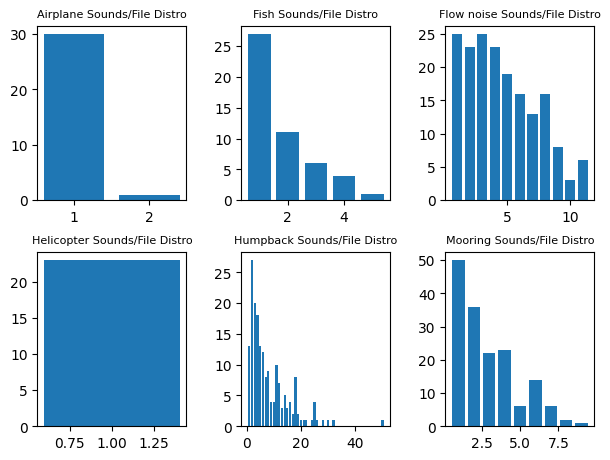

<Figure size 500x200 with 0 Axes>

In [24]:
#Seeing the distribution of sounds per file\
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
fig, axs = plt.subplots(nrows=2, ncols=3)
plt.figure(figsize=(5, 2))
axs[0,0].bar(x=count_files.loc[count_files['sound']=='airplane']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='airplane']['Metadata_files'])
axs[0,1].bar(x=count_files.loc[count_files['sound']=='fish']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='fish']['Metadata_files'])
axs[0,2].bar(x=count_files.loc[count_files['sound']=='flow noise']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='flow noise']['Metadata_files'])
axs[1,0].bar(x=count_files.loc[count_files['sound']=='helicopter']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='helicopter']['Metadata_files'])
axs[1,1].bar(x=count_files.loc[count_files['sound']=='humpback']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='humpback']['Metadata_files'])
axs[1,2].bar(x=count_files.loc[count_files['sound']=='mooring']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='mooring']['Metadata_files'])
fig.tight_layout(pad = 2.0)
axs[0,0].set_title('Airplane Sounds/File Distro', size = 8)
axs[0,1].set_title('Fish Sounds/File Distro', size = 8)
axs[0,2].set_title('Flow noise Sounds/File Distro', size = 8)
axs[1,0].set_title('Helicopter Sounds/File Distro', size = 8)
axs[1,1].set_title('Humpback Sounds/File Distro', size = 8)
axs[1,2].set_title('Mooring Sounds/File Distro', size = 8)
plt.show()